In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns


import matplotlib.pyplot as plt
from sklearn import datasets
from pathlib import Path


#sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

#Classifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier , LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from xgboost import XGBClassifier


from sklearn.svm import LinearSVR
from sklearn.svm import SVR

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

from sklearn.model_selection import cross_val_score ,learning_curve ,GridSearchCV
from sklearn_evaluation import plot

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler


from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import RBFSampler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import ConfusionMatrixDisplay


import warnings
warnings.filterwarnings('ignore')


# chemin pour le fichier py avec les foncitons
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))


# fonctions dans le fichier py 
from utils import detect_variable_types, winsorize_data

In [17]:
os.getcwd()

#dossier src/ au path
src_path = Path.cwd().parent / "src"
data_path = Path.cwd().parent / "data"

# récupereation des données 

df = pd.read_csv( data_path / "df_clean.csv")
print(df.shape)



(44552, 25)


In [18]:
# Suppression de la variable taille
df = df.drop(columns=['height(cm)'])

## Modélisation binaire


In [19]:
df.head()

,age,weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting_blood_sugar,Cholesterol,triglyceride,...,serum_creatinine,AST,ALT,Gtp,dental_caries,tartar,smoking,homme,pb_hearing(left),pb_hearing(right)
0,40,60,81.3,1.2,1.0,114.0,73.0,94.0,215.0,82.0,...,0.7,18.0,19.0,27.0,False,True,False,False,False,False
1,40,60,81.0,0.8,0.6,119.0,70.0,130.0,192.0,115.0,...,0.6,22.0,19.0,18.0,False,True,False,False,False,False
2,55,60,80.0,0.8,0.8,138.0,86.0,89.0,242.0,182.0,...,1.0,21.0,16.0,22.0,False,False,True,True,False,False
3,40,70,88.0,1.5,1.5,100.0,60.0,96.0,322.0,254.0,...,1.0,19.0,26.0,18.0,False,True,False,True,False,False
4,40,60,86.0,1.0,1.0,120.0,74.0,80.0,184.0,74.0,...,0.6,16.0,14.0,22.0,False,False,False,False,False,False


## Coréction des types 



In [20]:
types = detect_variable_types(df)

print(" Variables numériques :", types["numerical"])
print(" Variables catégorielles :", types["categorical"])
print(" Variables booléennes :", types["boolean"])

 Variables numériques : ['age', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'systolic', 'relaxation', 'fasting_blood_sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine_protein', 'serum_creatinine', 'AST', 'ALT', 'Gtp']
 Variables catégorielles : []
 Variables booléennes : ['dental_caries', 'tartar', 'smoking', 'homme', 'pb_hearing(left)', 'pb_hearing(right)']


Lors du rechargement du fichier CSV dans le notebook de modélisation, les types de variables doivent être explicitement restaurés. 
En effet, le format CSV ne conserve pas les métadonnées de type comme les booléens ou les catégories ordonnées.  
Nous allons donc recasté manuellement certaines colonnes (`Urine_protein` en catégorie ordonnée, les variables booléennes en `bool`) pour garantir la cohérence de l’analyse.

In [21]:
df["Urine_protein"] = pd.Categorical(df["Urine_protein"], 
                                     categories=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0], 
                                     ordered=True)

for col in ["dental_caries", "tartar", "homme", "pb_hearing(left)", "pb_hearing(right)"]:
    df[col] = df[col].astype(bool)


On sépare les variables par type pour appliquer un traitement adapté à chacune (standardisation pour les numériques, encodage pour les catégorielles, etc). Cette étape est aussi importante  pour pouvoir construire un pipeline

In [22]:
num_cols = types["numerical"]
bool_cols = types["boolean"]
ordinal_col = ['Urine_protein']

num_cols.remove("Urine_protein")
bool_cols.remove("smoking")

On extrait les variables explicatives (X) et la variable cible (y). On s’assure que la cible ne soit jamais utilisée dans les transformations pour éviter toute fuite de données (data leakage)

In [23]:
X = df[num_cols +  bool_cols + ordinal_col].copy()
y = df["smoking"].copy()

## data set en train et test
On sépare les données en ensemble d'entraînement (80%) et de test (20%) pour pouvoir évaluer la performance finale des modèles sur des données jamais vues

In [24]:
X_train , X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2 ,
                                                    shuffle=True ,
                                                    random_state=42
                                                   )

In [25]:
print("Dimensions de X_train:", X_train.shape)
print("Dimensions de X_test:", X_test.shape)
print("Dimensions de y_train:", y_train.shape)
print("Dimensions de y_test:", y_test.shape)

Dimensions de X_train: (35641, 23)
Dimensions de X_test: (8911, 23)
Dimensions de y_train: (35641,)
Dimensions de y_test: (8911,)


## Winsorization 

Certaines variables numériques présentaient des valeurs manifestement aberrantes ou extrêmement éloignées du reste de la distribution (par exemple ALT > 2900, LDL > 1800 ou créatinine > 11), pouvant fortement influencer l'apprentissage des modèles. Pour limiter l’effet de ces outliers sans supprimer d’observations, nous avons appliqué une winsorisation à 1%–99% sur les variables concernées. Ce choix permet de réduire l’impact des extrêmes tout en conservant la structure générale des données. Les colonnes sélectionnées l’ont été sur la base d’une analyse des statistiques descriptives et de la distribution de chaque variable.

In [26]:
columns_to_winsorize = [
    'ALT', 'AST', 'Gtp', 'serum_creatinine',
    'LDL', 'HDL', 'triglyceride', 'Cholesterol',
    'fasting_blood_sugar', 'systolic', 'relaxation', 'hemoglobin'
]

#Winsorize outliers
for col in X_train[columns_to_winsorize].columns:
    print(f" winsorization de la variable : {col}") 
    X_train[col], X_test[col] = winsorize_data(xtrain= X_train, xtest= X_test, feature=col)

 winsorization de la variable : ALT
 winsorization de la variable : AST
 winsorization de la variable : Gtp
 winsorization de la variable : serum_creatinine
 winsorization de la variable : LDL
 winsorization de la variable : HDL
 winsorization de la variable : triglyceride
 winsorization de la variable : Cholesterol
 winsorization de la variable : fasting_blood_sugar
 winsorization de la variable : systolic
 winsorization de la variable : relaxation
 winsorization de la variable : hemoglobin


### Pipeline de préparation des données

**Standardisation des variables numériques**

**Encodage ordinal de la variable Urine_protein**

**Passage direct des variables booléennes**


ColumnTransformer permet d’appliquer des transformations spécifiques à chaque type de variable. Et la Pipeline regroupe toutes les étapes de prétraitement

In [27]:

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('ord', OrdinalEncoder(), ordinal_col),
    ('bool', 'passthrough', bool_cols)
])

pipeline = Pipeline([
    ('preprocessing', preprocessor)
])


### Fit-transform sur X_train
On ajuste le prétraitement sur le train (fit_transform), puis on applique exactement le même traitement au test (transform), ce qui garantit cohérence et absence de fuite

In [28]:
# Fit + transformation
X_train_prepared = pipeline.fit_transform(X_train)
X_test_prepared = pipeline.transform(X_test)



In [29]:
# Création du nom des colonnes
# Les colonnes ordinales gardent leur nom
all_columns = num_cols + ordinal_col + bool_cols

# Reconstruction des DataFrames
X_train_df = pd.DataFrame(X_train_prepared, columns=all_columns, index=X_train.index)
X_test_df = pd.DataFrame(X_test_prepared, columns=all_columns, index=X_test.index)


## Modeles
On choisit trois modèles de nature différente : linéaire, non-linéaire à noyau, et arbre aléatoire pour capturer différentes structures dans les données et les comparer

In [30]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    #"XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SVC (RBF Kernel)": SVC(kernel='rbf', random_state=42),
    "SVC (Linear Kernel)": SVC(kernel='linear', random_state=42),
    "SVC (Poly Kernel)": SVC(kernel='poly', random_state=42),
    "LinearSVC": LinearSVC(max_iter=2000, random_state=42),
    "SGDClassifier": SGDClassifier(random_state=42)
}


On entraîne chaque modèle, puis on calcule l’accuracy sur train, test, et en validation croisée, pour juger à la fois de la performance et de la robustesse du modèle

In [31]:
# Boucle d'entraînement et évaluation
results = []

for name, model in models.items():
    print(f"\n{'='*40}\n Modèle : {name}\n{'='*40}")

    # Entraînement
    model.fit(X_train, y_train)
    print("Paramètres utilisés :", model.get_params())


    for split_name, X, y_true in [("Train", X_train, y_train), ("Test", X_test, y_test)]:
        y_pred = model.predict(X)

        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        error_rate = 1 - acc
        cm = confusion_matrix(y_true, y_pred)

        # Affichage
        print(f"\n Résultats sur {split_name} :")
        print(f" Accuracy       : {acc:.4f}")
        print(f" Taux d'erreur  : {error_rate:.4f}")
        print(f" Précision      : {precision:.4f}")
        print(f" Recall         : {recall:.4f}")
        print(f" F1-score       : {f1:.4f}")
        print(" Matrice de confusion :")
        print(cm)

        # Sauvegarde des résultats
        results.append({
            "Modèle": name,
            "Données": split_name,
            "Accuracy": acc,
            "Erreur": error_rate,
            "Précision": precision,
            "Recall": recall,
            "F1-score": f1
        })

# Création d’un DataFrame récapitulatif
results_df = pd.DataFrame(results)
print("\n Récapitulatif des performances :")
display(results_df)



 Modèle : Logistic Regression
Paramètres utilisés : {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

 Résultats sur Train :
 Accuracy       : 0.7221
 Taux d'erreur  : 0.2779
 Précision      : 0.6334
 Recall         : 0.5769
 F1-score       : 0.6039
 Matrice de confusion :
[[18185  4369]
 [ 5537  7550]]

 Résultats sur Test :
 Accuracy       : 0.7271
 Taux d'erreur  : 0.2729
 Précision      : 0.6389
 Recall         : 0.5868
 F1-score       : 0.6117
 Matrice de confusion :
[[4563 1083]
 [1349 1916]]

 Modèle : Random Forest
Paramètres utilisés : {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf

,Modèle,Données,Accuracy,Erreur,Précision,Recall,F1-score
0,Logistic Regression,Train,0.722062,0.277938,0.633442,0.576908,0.603855
1,Logistic Regression,Test,0.727079,0.272921,0.638880,0.586830,0.611750
2,Random Forest,Train,0.999972,0.000028,1.000000,0.999924,0.999962
3,Random Forest,Test,0.758276,0.241724,0.662760,0.692802,0.677448
4,Gradient Boosting,Train,0.769619,0.230381,0.673080,0.724459,0.697825
5,Gradient Boosting,Test,0.763551,0.236449,0.664769,0.715467,0.689187
6,SVC (RBF Kernel),Train,0.713532,0.286468,0.669495,0.434171,0.526745
7,SVC (RBF Kernel),Test,0.714959,0.285041,0.668526,0.440429,0.531019
8,SVC (Linear Kernel),Train,0.745602,0.254398,0.640894,0.698632,0.668519
9,SVC (Linear Kernel),Test,0.753226,0.246774,0.648056,0.714548,0.679680


Cross-validation pour Logistic Regression
Cross-validation pour Random Forest
Cross-validation pour Gradient Boosting
Cross-validation pour SVC (RBF Kernel)
Cross-validation pour SVC (Linear Kernel)
Cross-validation pour SVC (Poly Kernel)
Cross-validation pour LinearSVC
Cross-validation pour SGDClassifier


,Logistic Regression,Random Forest,Gradient Boosting,SVC (RBF Kernel),SVC (Linear Kernel),SVC (Poly Kernel),LinearSVC,SGDClassifier
Fold 1,0.579668,0.667040,0.684962,0.516760,0.660084,0.536328,0.664850,0.000000
Fold 2,0.580901,0.669417,0.681290,0.524376,0.673123,0.553153,0.678689,0.052476
Fold 3,0.582193,0.668545,0.682384,0.509638,0.672170,0.538160,0.671065,0.037244
Fold 4,0.570887,0.668159,0.689352,0.518260,0.672737,0.549705,0.671965,0.299416
Fold 5,0.581766,0.667290,0.681262,0.522839,0.665223,0.545287,0.662784,0.584317



Résumé des performances (moyenne ± écart-type) :


,Modèle,Moyenne F1-score,Écart-type
0,Logistic Regression,0.579083,0.004682
1,Random Forest,0.668090,0.000964
2,Gradient Boosting,0.683850,0.003425
3,SVC (RBF Kernel),0.518375,0.005807
4,SVC (Linear Kernel),0.668667,0.005793
5,SVC (Poly Kernel),0.544527,0.007238
6,LinearSVC,0.669871,0.006305
7,SGDClassifier,0.194691,0.247838


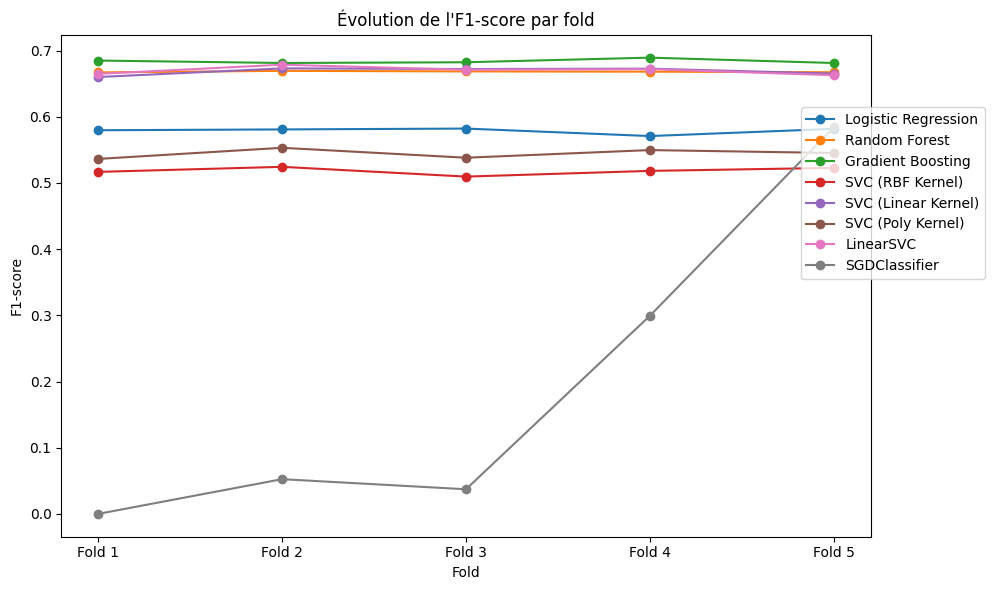

In [43]:
# Résultats de cross-validation
cv_results = {}
n_folds = 5

for name, model in models.items():
    print(f"Cross-validation pour {name}")
    scores = cross_val_score(model, X_train, y_train, cv=n_folds, scoring='f1')
    cv_results[name] = scores

# Convertir en DataFrame
df_cv = pd.DataFrame(cv_results)
df_cv.index = [f"Fold {i+1}" for i in range(n_folds)]

# Afficher les scores
display(df_cv)

# Moyenne et écart-type
summary_df = pd.DataFrame({
    "Modèle": df_cv.columns,
    "Moyenne F1-score": df_cv.mean().values,
    "Écart-type": df_cv.std().values
})
print("\nRésumé des performances (moyenne ± écart-type) :")
display(summary_df)

# Visualisation
plt.figure(figsize=(10, 6))
for model in df_cv.columns:
    plt.plot(df_cv.index, df_cv[model], marker='o', label=model)
plt.title("Évolution de l'F1-score par fold")
plt.ylabel("F1-score")
plt.xlabel("Fold")
plt.legend(loc="lower right", bbox_to_anchor=(1.15, 0.5))
plt.tight_layout()
plt.show()


**Modeles avec scoring recall**

# Optimisation des modèles

Comme nous l'avons déjà mentionné, notre variable cible présente un déséquilibre modéré entre les classes (environ 63 % de non-fumeurs contre 37 % de fumeurs).
Afin d’éviter que les modèles ne soient biaisés en faveur de la classe majoritaire, nous avons mis en œuvre des techniques de resampling, appliquées uniquement sur le jeu d’entraînement.

Dans notre cas, nous avons retenu le RandomUnderSampler, qui consiste à réduire le nombre d’exemples de la classe majoritaire (non-fumeurs), afin d’équilibrer la distribution sans générer de données synthétiques.

Cette étape a été suivie d’une recherche des meilleurs hyperparamètres via validation croisée (GridSearchCV), en optimisant la métrique de rappel (recall) — particulièrement pertinente dans notre problématique, où l’objectif est de maximiser la détection des fumeurs.

Nous avons procédé en trois temps :

GridSearchCV seul, sans rééquilibrage,

Resampling seul, sans optimisation,

Et enfin, combinaison des deux : resampling suivi d’une optimisation.

Dans une dernière étape, nous avons également expérimenté une sélection automatique de variables, afin de simplifier les modèles et améliorer leur interprétabilité.

À partir de notre pipeline, nous avons optimisé séparément les deux modèles retenus :

LinearSVC (modèle linéaire)

GradientBoostingClassifier (modèle non-linéaire)

## 1. Optimisation LinearSVC

In [115]:
results = []

# Repartir proprement
X = df[num_cols + bool_cols + ordinal_col].copy()
y = df["smoking"].copy()

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Winsorisation
for col in columns_to_winsorize:
    X_train[col], X_test[col] = winsorize_data(X_train, X_test, feature=col)

# Préprocessing commun
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('ord', OrdinalEncoder(), ordinal_col),
    ('bool', 'passthrough', bool_cols)
])

# Grille de recherche
param_grid = {
    'model__C': [0.01, 0.1, 1, 10]
}

**GridSearch**

Fitting 5 folds for each of 4 candidates, totalling 20 fits
=== Résultats : LinearSVC (GridSearch seul) ===
Recall     : 0.7228177641653905
F1-score   : 0.6822781150621567
Accuracy   : 0.753338570306363
Precision  : 0.6460443471119628
Matrice de confusion :
 [[4353 1293]
 [ 905 2360]]
Best Params: {'model__C': 1}


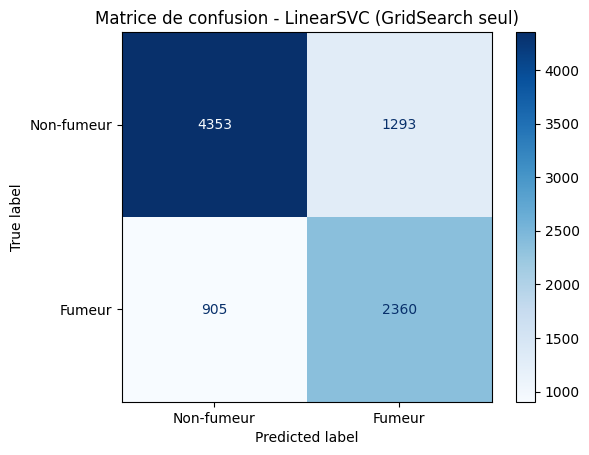

In [116]:
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LinearSVC(max_iter=2000, random_state=42))
])

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

#  Entraînement
grid_search.fit(X_train, y_train)
y_pred = grid_search.best_estimator_.predict(X_test)

# Affichage des résultats
print("=== Résultats : LinearSVC (GridSearch seul) ===")
print("Recall     :", recall_score(y_test, y_pred))
print("F1-score   :", f1_score(y_test, y_pred))
print("Accuracy   :", accuracy_score(y_test, y_pred))
print("Precision  :", precision_score(y_test, y_pred))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("Best Params:", grid_search.best_params_)

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["Non-fumeur", "Fumeur"], cmap="Blues"
)
plt.title("Matrice de confusion - LinearSVC (GridSearch seul)")
plt.show()

# Stockage dans results
results.append({
    "Nom": "LinearSVC - GridSearch seul",
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Best Params": grid_search.best_params_
})

**Resampling sans GridSearch**


=== Résultats : LinearSVC - Undersampling seul ===
Recall     : 0.9375191424196019
F1-score   : 0.7079912108245634
Accuracy   : 0.7166423521490293
Precision  : 0.5687476774433297
Matrice de confusion :
 [[3325 2321]
 [ 204 3061]]


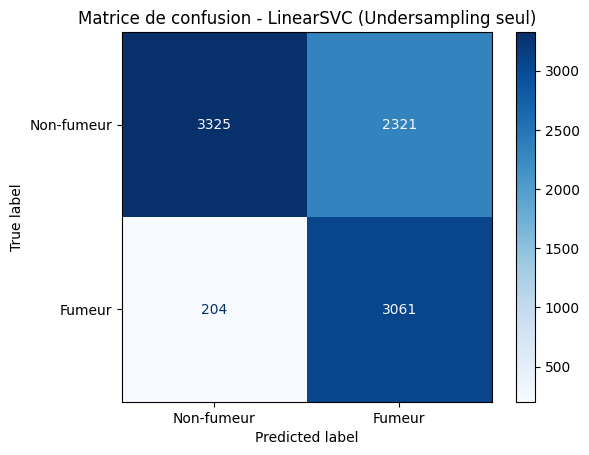

In [117]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

pipeline_resample_no_grid = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LinearSVC(C=1, max_iter=2000, random_state=42))  # Valeur par défaut
])

pipeline_resample_no_grid.fit(X_resampled, y_resampled)
y_pred_resample_only = pipeline_resample_no_grid.predict(X_test)

print("\n=== Résultats : LinearSVC - Undersampling seul ===")
print("Recall     :", recall_score(y_test, y_pred_resample_only))
print("F1-score   :", f1_score(y_test, y_pred_resample_only))
print("Accuracy   :", accuracy_score(y_test, y_pred_resample_only))
print("Precision  :", precision_score(y_test, y_pred_resample_only))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_resample_only))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_resample_only,
    display_labels=["Non-fumeur", "Fumeur"], cmap="Blues"
)
plt.title("Matrice de confusion - LinearSVC (Undersampling seul)")
plt.show()

# Ajout aux résultats
results.append({
    "Nom": "LinearSVC - Undersampling seul",
    "Recall": recall_score(y_test, y_pred_resample_only),
    "F1-score": f1_score(y_test, y_pred_resample_only),
    "Accuracy": accuracy_score(y_test, y_pred_resample_only),
    "Precision": precision_score(y_test, y_pred_resample_only),
    "Best Params": "C=1 (défaut)"
})


**Resampling & Grid Search Pipeline**

Fitting 5 folds for each of 4 candidates, totalling 20 fits

=== Résultats : LinearSVC - GridSearch + Undersampling ===
Recall     : 0.9375191424196019
F1-score   : 0.7082369273484498
Accuracy   : 0.7169790147009314
Precision  : 0.5690648819483175
Matrice de confusion :
 [[3328 2318]
 [ 204 3061]]
Best Params: {'model__C': 0.01}


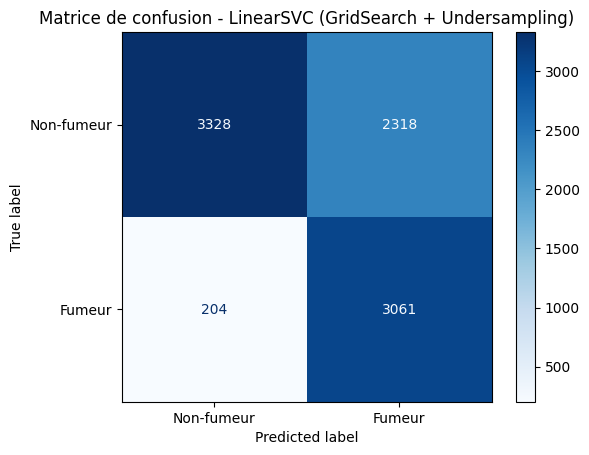

In [118]:

# Repartir proprement
X = df[num_cols + bool_cols + ordinal_col].copy()
y = df["smoking"].copy()

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Winsorisation 
for col in columns_to_winsorize:
    X_train[col], X_test[col] = winsorize_data(X_train, X_test, feature=col)

# --- Undersampling + GridSearch
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LinearSVC(max_iter=2000, random_state=42))
])

param_grid = {
    'model__C': [0.01, 0.1, 1, 10]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_resampled, y_resampled)
best_model = grid_search.best_estimator_
y_pred_undersample_grid = best_model.predict(X_test)

print("\n=== Résultats : LinearSVC - GridSearch + Undersampling ===")
print("Recall     :", recall_score(y_test, y_pred_undersample_grid))
print("F1-score   :", f1_score(y_test, y_pred_undersample_grid))
print("Accuracy   :", accuracy_score(y_test, y_pred_undersample_grid))
print("Precision  :", precision_score(y_test, y_pred_undersample_grid))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_undersample_grid))
print("Best Params:", grid_search.best_params_)

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_undersample_grid,
    display_labels=["Non-fumeur", "Fumeur"], cmap="Blues"
)
plt.title("Matrice de confusion - LinearSVC (GridSearch + Undersampling)")
plt.show()

# Ajout aux résultats
results.append({
    "Nom": "LinearSVC - GridSearch + Undersampling",
    "Recall": recall_score(y_test, y_pred_undersample_grid),
    "F1-score": f1_score(y_test, y_pred_undersample_grid),
    "Accuracy": accuracy_score(y_test, y_pred_undersample_grid),
    "Precision": precision_score(y_test, y_pred_undersample_grid),
    "Best Params": grid_search.best_params_
})


#####  Sélection des variables pour LinearSVC 


 Variables sélectionnées : [np.str_('systolic'), np.str_('relaxation'), np.str_('Cholesterol'), np.str_('triglyceride'), np.str_('hemoglobin'), np.str_('serum_creatinine'), np.str_('ALT'), np.str_('Gtp'), np.str_('dental_caries'), np.str_('tartar'), np.str_('homme'), np.str_('pb_hearing(left)')]

 Résultats après sélection de variables :
Recall     : 0.7197549770290965
F1-score   : 0.6816533720087019
Accuracy   : 0.7536752328582651
Precision  : 0.6473829201101928
Matrice de confusion :
 [[4366 1280]
 [ 915 2350]]


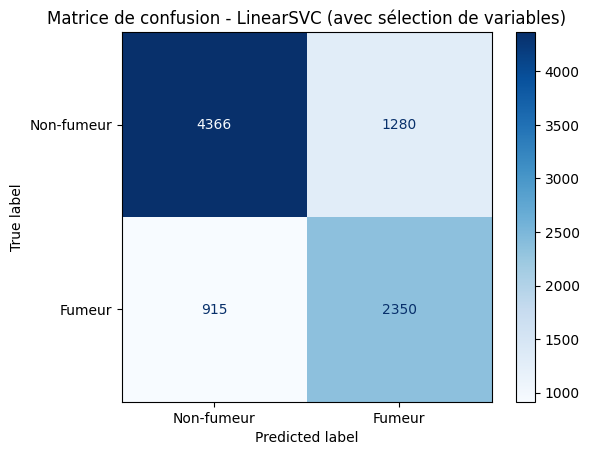

In [119]:
#  Récupération du modèle LinearSVC optimisé depuis le pipeline
final_svc = best_model.named_steps['model']
final_preproc = best_model.named_steps['preprocessing']

# Transformation des données brutes
X_train_processed = final_preproc.transform(X_train)
X_test_processed = final_preproc.transform(X_test)

# Noms des colonnes 
all_features = num_cols + ordinal_col + bool_cols

# Sélection automatique de variables
sfm = SelectFromModel(estimator=final_svc, threshold='median', prefit=True)
mask = sfm.get_support()
selected_features = np.array(all_features)[mask]
print(" Variables sélectionnées :", list(selected_features))

# Réduction des données transformées
X_train_selected = sfm.transform(X_train_processed)
X_test_selected = sfm.transform(X_test_processed)

# Récupération dynamique du meilleur C
best_params = grid_search.best_params_
C_value = best_params.get('model__C', best_params.get('C', 1.0)) 

#  Réentraînement final sur les variables sélectionnées
final_model = LinearSVC(C=C_value, max_iter=2000, random_state=42)
final_model.fit(X_train_selected, y_train)

# Évaluation finale sur test réduit
y_pred_selected = final_model.predict(X_test_selected)

print("\n Résultats après sélection de variables :")
print("Recall     :", recall_score(y_test, y_pred_selected))
print("F1-score   :", f1_score(y_test, y_pred_selected))
print("Accuracy   :", accuracy_score(y_test, y_pred_selected))
print("Precision  :", precision_score(y_test, y_pred_selected))


# Affichage de la matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_selected))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_selected,
    display_labels=["Non-fumeur", "Fumeur"],
    cmap="Blues"
)
plt.title("Matrice de confusion - LinearSVC (avec sélection de variables)")
plt.show()

# Ajout dans le tableau des résultats
results.append({
    "Nom": "LinearSVC - Sélection de variables",
    "Recall": recall_score(y_test, y_pred_selected),
    "F1-score": f1_score(y_test, y_pred_selected),
    "Accuracy": accuracy_score(y_test, y_pred_selected),
    "Precision": precision_score(y_test, y_pred_selected),
    "Best Params": f"C={C_value}, vars: {list(selected_features)}"
})



## 2. Gradient Boosting 

In [120]:

# Repartir proprement
X = df[num_cols + bool_cols + ordinal_col].copy()
y = df["smoking"].copy()

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Winsorisation
for col in columns_to_winsorize:
    X_train[col], X_test[col] = winsorize_data(X_train, X_test, feature=col)

# Préprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('ord', OrdinalEncoder(), ordinal_col),
    ('bool', 'passthrough', bool_cols)
])

# Grille d’hyperparamètres
param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 4]
}


**GridSearchCV seul (sans resampling)**

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Résultats Gradient Boosting - GridSearch seul :
Recall     : 0.7145482388973966
F1-score   : 0.6884036588964296
Accuracy   : 0.7629895634608911
Precision  : 0.6641047537717051
Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 200}
Matrice de confusion :
 [[4466 1180]
 [ 932 2333]]


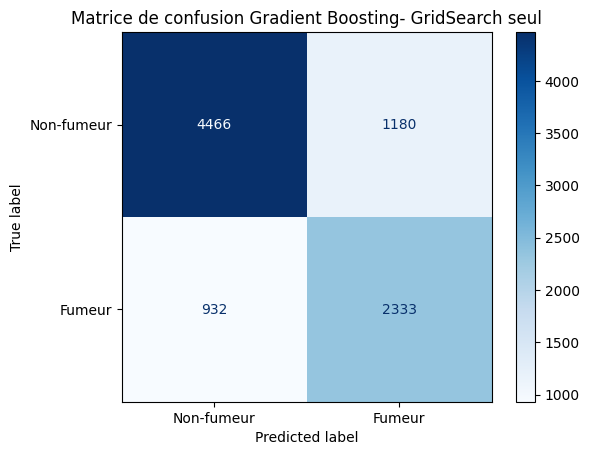

In [121]:

pipeline1 = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingClassifier(random_state=42))
])

grid1 = GridSearchCV(pipeline1, param_grid, scoring='recall', cv=5, n_jobs=-1, verbose=1)
grid1.fit(X_train, y_train)

y_pred1 = grid1.best_estimator_.predict(X_test)

results.append({
    "Nom": "Gradient Boosting - GridSearch seul",
    "Recall": recall_score(y_test, y_pred1),
    "F1-score": f1_score(y_test, y_pred1),
    "Accuracy": accuracy_score(y_test, y_pred1),
    "Precision": precision_score(y_test, y_pred1),
    "Best Params": grid1.best_params_
})


print("Résultats Gradient Boosting - GridSearch seul :")
print("Recall     :", recall_score(y_test, y_pred1))
print("F1-score   :", f1_score(y_test, y_pred1))
print("Accuracy   :", accuracy_score(y_test, y_pred1))
print("Precision  :", precision_score(y_test, y_pred1))
print("Best Params:", grid1.best_params_)
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred1))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred1, display_labels=["Non-fumeur", "Fumeur"], cmap="Blues"
)
plt.title("Matrice de confusion Gradient Boosting- GridSearch seul")
plt.show()

**RandomUnderSampler seul (sans GridSearch)**

Résultats Gradient Boosting- Undersampling seul :
Recall     : 0.8918836140888208
F1-score   : 0.7201681711388649
Accuracy   : 0.7460442150151498
Precision  : 0.6038987971795935
Matrice de confusion :
 [[3736 1910]
 [ 353 2912]]


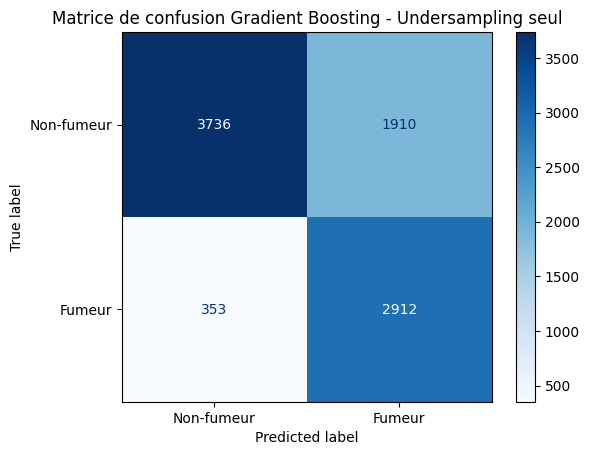

In [122]:
rus = RandomUnderSampler(random_state=42)
X_resampled2, y_resampled2 = rus.fit_resample(X_train, y_train)

pipeline2 = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42  # valeurs par défaut
    ))
])

pipeline2.fit(X_resampled2, y_resampled2)
y_pred2 = pipeline2.predict(X_test)

results.append({
    "Nom": "Gradient Boosting  - Undersampling seul",
    "Recall": recall_score(y_test, y_pred2),
    "F1-score": f1_score(y_test, y_pred2),
    "Accuracy": accuracy_score(y_test, y_pred2),
    "Precision": precision_score(y_test, y_pred2),
    "Best Params": "default"
})

print("Résultats Gradient Boosting- Undersampling seul :")
print("Recall     :", recall_score(y_test, y_pred2))
print("F1-score   :", f1_score(y_test, y_pred2))
print("Accuracy   :", accuracy_score(y_test, y_pred2))
print("Precision  :", precision_score(y_test, y_pred2))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred2))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred2, display_labels=["Non-fumeur", "Fumeur"], cmap="Blues"
)
plt.title("Matrice de confusion Gradient Boosting - Undersampling seul")
plt.show()



**GridSearchCV + Undersampling**

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Résultats Gradient Boosting - GridSearch + Undersampling :
Recall     : 0.9139356814701378
F1-score   : 0.7159309021113244
Accuracy   : 0.7342610256985748
Precision  : 0.5884440938670874
Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}
Matrice de confusion :
 [[3559 2087]
 [ 281 2984]]


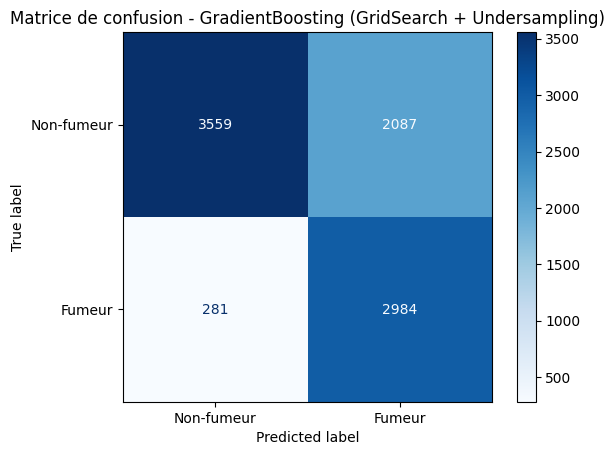

In [123]:
# === GridSearch + Undersampling pour GradientBoostingClassifier ===
X_resampled_gb, y_resampled_gb = rus.fit_resample(X_train, y_train)

pipeline_gb = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingClassifier(random_state=42))
])

grid_search_gb = GridSearchCV(
    estimator=pipeline_gb,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search_gb.fit(X_resampled_gb, y_resampled_gb)

y_pred_gb = grid_search_gb.best_estimator_.predict(X_test)

# Ajout aux résultats
results.append({
    "Nom": "Gradient Boosting  - GridSearch + Undersampling",
    "Recall": recall_score(y_test, y_pred_gb),
    "F1-score": f1_score(y_test, y_pred_gb),
    "Accuracy": accuracy_score(y_test, y_pred_gb),
    "Precision": precision_score(y_test, y_pred_gb),
    "Best Params": grid_search_gb.best_params_
})

# Affichage
print("Résultats Gradient Boosting - GridSearch + Undersampling :")
print("Recall     :", recall_score(y_test, y_pred_gb))
print("F1-score   :", f1_score(y_test, y_pred_gb))
print("Accuracy   :", accuracy_score(y_test, y_pred_gb))
print("Precision  :", precision_score(y_test, y_pred_gb))
print("Best Params:", grid_search_gb.best_params_)
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_gb))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_gb,
    display_labels=["Non-fumeur", "Fumeur"],
    cmap="Blues"
)
plt.title("Matrice de confusion - GradientBoosting (GridSearch + Undersampling)")
plt.show()


#####  Sélection des variables pour GradientBoostingClassifier 

🔍 Variables sélectionnées : [np.str_('age'), np.str_('waist(cm)'), np.str_('triglyceride'), np.str_('LDL'), np.str_('hemoglobin'), np.str_('serum_creatinine'), np.str_('AST'), np.str_('ALT'), np.str_('Gtp'), np.str_('dental_caries'), np.str_('tartar'), np.str_('homme')]

Résultats Gradient Boosting (sélection de variables) :
Recall     : 0.7151607963246555
F1-score   : 0.6853536835926035
Accuracy   : 0.7593984962406015
Precision  : 0.6579318117779657
Matrice de confusion :
 [[4432 1214]
 [ 930 2335]]


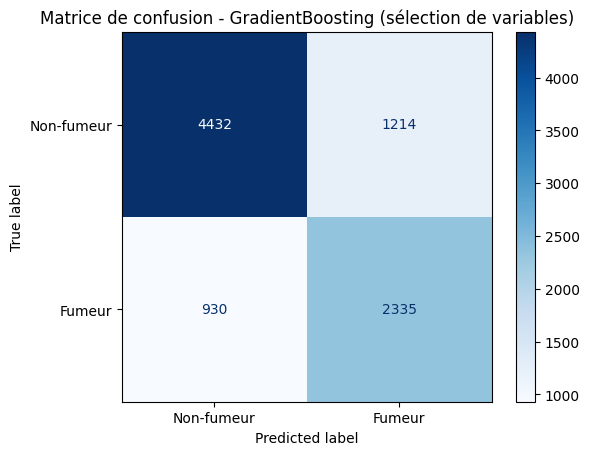

In [124]:

# Récupération du modèle Gradient Boosting optimisé
final_gb = grid_search_gb.best_estimator_.named_steps['model']
final_preproc = grid_search_gb.best_estimator_.named_steps['preprocessing']

# Transformation des données
X_train_processed = final_preproc.transform(X_train)
X_test_processed = final_preproc.transform(X_test)

# Noms des colonnes
all_features = num_cols + ordinal_col + bool_cols

# Sélection des variables importantes selon feature_importances_
sfm = SelectFromModel(estimator=final_gb, threshold='median', prefit=True)
mask = sfm.get_support()
selected_features = np.array(all_features)[mask]
print("🔍 Variables sélectionnées :", list(selected_features))

# Réduction des jeux de données
X_train_selected = sfm.transform(X_train_processed)
X_test_selected = sfm.transform(X_test_processed)

# Nettoyage des paramètres pour réentraînement
best_gb_params = grid_search_gb.best_params_
clean_params = {k.replace("model__", ""): v for k, v in best_gb_params.items()}

# Réentraînement sur les variables sélectionnées
final_model = GradientBoostingClassifier(**clean_params, random_state=42)
final_model.fit(X_train_selected, y_train)

# Évaluation
y_pred_selected = final_model.predict(X_test_selected)

print("\nRésultats Gradient Boosting (sélection de variables) :")
print("Recall     :", recall_score(y_test, y_pred_selected))
print("F1-score   :", f1_score(y_test, y_pred_selected))
print("Accuracy   :", accuracy_score(y_test, y_pred_selected))
print("Precision  :", precision_score(y_test, y_pred_selected))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_selected))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_selected,
    display_labels=["Non-fumeur", "Fumeur"],
    cmap="Blues"
)
plt.title("Matrice de confusion - GradientBoosting (sélection de variables)")
plt.show()

# Ajout au tableau de résultats
results.append({
    "Nom": "GradientBoosting - Sélection de variables",
    "Recall": recall_score(y_test, y_pred_selected),
    "F1-score": f1_score(y_test, y_pred_selected),
    "Accuracy": accuracy_score(y_test, y_pred_selected),
    "Precision": precision_score(y_test, y_pred_selected),
    "Best Params": f"{clean_params}, vars: {list(selected_features)}"
})


In [125]:
df_results = pd.DataFrame(results)
print("\nComparatif des optimisations pour LinearSVC et Gradient Boosting  :")
display(df_results)


Comparatif des optimisations pour LinearSVC et Gradient Boosting  :


,Nom,Recall,F1-score,Accuracy,Precision,Best Params
0,LinearSVC - GridSearch seul,0.722818,0.682278,0.753339,0.646044,{'model__C': 1}
1,LinearSVC - Undersampling seul,0.937519,0.707991,0.716642,0.568748,C=1 (défaut)
2,LinearSVC - GridSearch + Undersampling,0.937519,0.708237,0.716979,0.569065,{'model__C': 0.01}
3,LinearSVC - Sélection de variables,0.719755,0.681653,0.753675,0.647383,"C=0.01, vars: [np.str_('systolic'), np.str_('r..."
4,Gradient Boosting - GridSearch seul,0.714548,0.688404,0.762990,0.664105,"{'model__learning_rate': 0.05, 'model__max_dep..."
5,Gradient Boosting - Undersampling seul,0.891884,0.720168,0.746044,0.603899,default
6,Gradient Boosting - GridSearch + Undersampling,0.913936,0.715931,0.734261,0.588444,"{'model__learning_rate': 0.05, 'model__max_dep..."
7,GradientBoosting - Sélection de variables,0.715161,0.685354,0.759398,0.657932,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est..."
